In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from torch.utils.data import random_split


In [2]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# 각 미니 배치에 32개의 샘플이 포함됨
batch_size = 32

# 학습용 dataset, 테스트용 dataset 준비
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        # transforms.Compose()를 사용하여 이전에 정의된 변환 파이프라인으로 설정
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='data/', train=False, transform=transform)

# 데이터셋 8:2 비율로 분리
torch.manual_seed(43)
val_size = 10000
train_size = len(dataset) - val_size  # train_size = 40000 , valsize = 10000
train_ds, val_ds = random_split(dataset, [train_size, val_size])

print(len(dataset))  # 50000
print(len(train_ds)) # 40000 학습용 데이터셋
print(len(val_ds))   # 10000 검증용 데이터셋
print(train_size)    # 40000
# len(train_ds), len(val_ds)

# num_workers : 데이터 로드에 사용할 하위 프로세스 수
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

validationloader = DataLoader(val_ds, batch_size=batch_size*2, shuffle=False, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

## loss function의 train_loss 와 validation_loss
loss_train = []
loss_validation = []

## train & validation accuracy 
train_acc_list = []
val_acc_list = []

model = torchvision.models.alexnet(pretrained=True)

## CUDA 기기가 존재한다면, CUDA 장치를 출력:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)


# 3. 손실 함수 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)


# 4. 학습용 데이터를 사용하여 신경망 학습
n = len(trainloader)
m = len(validationloader)

for epoch in range(30):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training Phase
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        # inputs, labels = data # cuda 사용
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력
        running_loss += loss.item()

        # training accuracy 계산
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        if i % n == n-1:
            print(f'Training : [{epoch + 1}, {i + 1:5d}] loss: {running_loss / n:.3f} accuracy: {correct_predictions / total_predictions:.3f}')
            loss_train.append(running_loss / n)
            # train data 정확도 기록하는 부분
            train_acc_list.append(correct_predictions / total_predictions)
            running_loss = 0.0
    
    

    # Validation Phase
    for i, data in enumerate(validationloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # validation accuracy 계산
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        
        # 통계를 출력
        running_loss += loss.item()
        if i % m == m-1:
            print(f'Validation : [{epoch + 1}, {i + 1:5d}] loss: {running_loss / m:.3f} accuracy: {correct_predictions / total_predictions:.3f}')
            loss_validation.append(running_loss / m)
            # validation data 정확도 기록하는 부분
            val_acc_list.append(correct_predictions / total_predictions)
            running_loss = 0.0


print('Finished Training\n')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
50000
40000
10000
40000
Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

cuda:0
Training : [1,  1250] loss: 1.042 accuracy: 0.640
Validation : [1,   157] loss: 0.613 accuracy: 0.670
Training : [2,  1250] loss: 0.517 accuracy: 0.821
Validation : [2,   157] loss: 0.496 accuracy: 0.822
Training : [3,  1250] loss: 0.396 accuracy: 0.864
Validation : [3,   157] loss: 0.406 accuracy: 0.863
Training : [4,  1250] loss: 0.318 accuracy: 0.888
Validation : [4,   157] loss: 0.385 accuracy: 0.884
Training : [5,  1250] loss: 0.262 accuracy: 0.910
Validation : [5,   157] loss: 0.382 accuracy: 0.902
Training : [6,  1250] loss: 0.217 accuracy: 0.923
Validation : [6,   157] loss: 0.371 accuracy: 0.913
Training : [7,  1250] loss: 0.182 accuracy: 0.937
Validation : [7,   157] loss: 0.360 accuracy: 0.926
Training : [8,  1250] loss: 0.150 accuracy: 0.949
Validation : [8,   157] loss: 0.375 accuracy: 0.935
Training : [9,  1250] loss: 0.131 accuracy: 0.955
Validation : [9,   157] loss: 0.379 accuracy: 0.940
Training : [10,  1250] loss: 0.107 accuracy: 0.962
Validation : [10,   157]

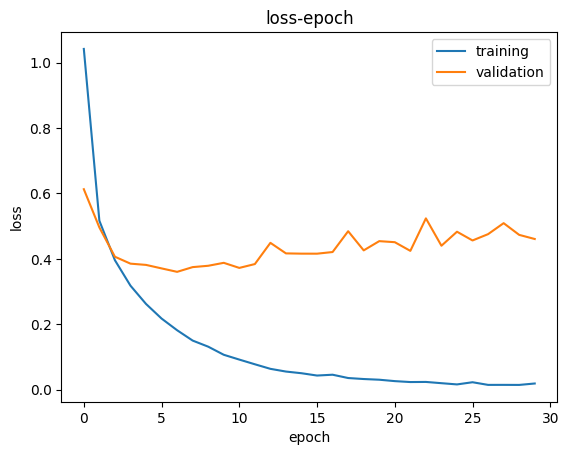

In [3]:
# 5. loss - epoch 그래프 출력
plt.title("loss-epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_train, label = 'training')
plt.plot(loss_validation, label = 'validation')
plt.legend()

Accuracy for class: plane is 93.0 %
Accuracy for class: car   is 95.6 %
Accuracy for class: bird  is 88.0 %
Accuracy for class: cat   is 81.6 %
Accuracy for class: deer  is 89.0 %
Accuracy for class: dog   is 81.9 %
Accuracy for class: frog  is 92.1 %
Accuracy for class: horse is 93.4 %
Accuracy for class: ship  is 90.0 %
Accuracy for class: truck is 93.7 %


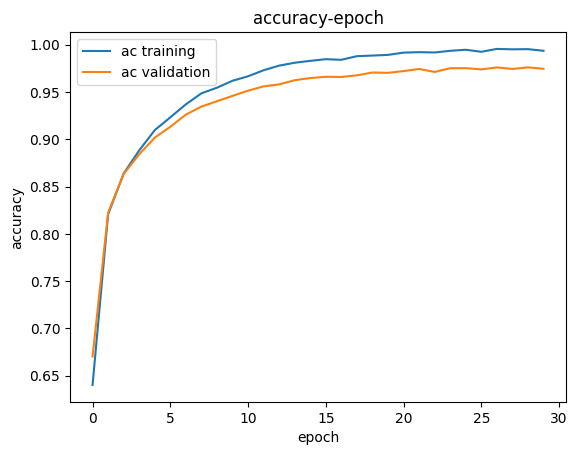

In [5]:




# 5. accuracy - epoch 그래프 출력
plt.title("accuracy-epoch")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot(train_acc_list, label = 'ac training')
plt.plot(val_acc_list, label = 'ac validation')
plt.legend()

# 학습한 모델 저장
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도 필요 없음
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)

        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [7]:
def compute_f1score(model, testloader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

test_f1 = compute_f1score(model, testloader, device)
print('Test F1 score: {:.4f}'.format(test_f1))

Test F1 score: 0.9109
